In [1]:
#Setup
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
def center_align_mask(mask, output_size=(320, 320)):
    """
    Pads the mask so that the segmented region is centered.
    """
    coords = cv2.findNonZero(mask.astype(np.uint8))
    if coords is None:
        return np.zeros(output_size, dtype=np.uint8)

    x, y, w, h = cv2.boundingRect(coords)
    cropped = mask[y:y+h, x:x+w]

    centered_mask = np.zeros(output_size, dtype=np.uint8)
    ch, cw = output_size
    y_offset = (ch - h) // 2
    x_offset = (cw - w) // 2
    centered_mask[y_offset:y_offset+h, x_offset:x_offset+w] = cropped

    return centered_mask

In [3]:
# Preprocessing Function
def preprocess_image(image_path, target_size=(320, 320)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
# Loading Quantized TFLite Model
interpreter = tf.lite.Interpreter(model_path="/content/u2net_quant_float16.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Loading Image & Run Inference
image_path = "/content/p1_LeftRing.jpg"  # Replace with actual image path
input_tensor = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

# Postprocessing Output
pred_mask = output[0, :, :, 0]
binary_mask = (pred_mask > 0.5).astype(np.uint8)

# Applying Centering
centered_mask = center_align_mask(binary_mask)


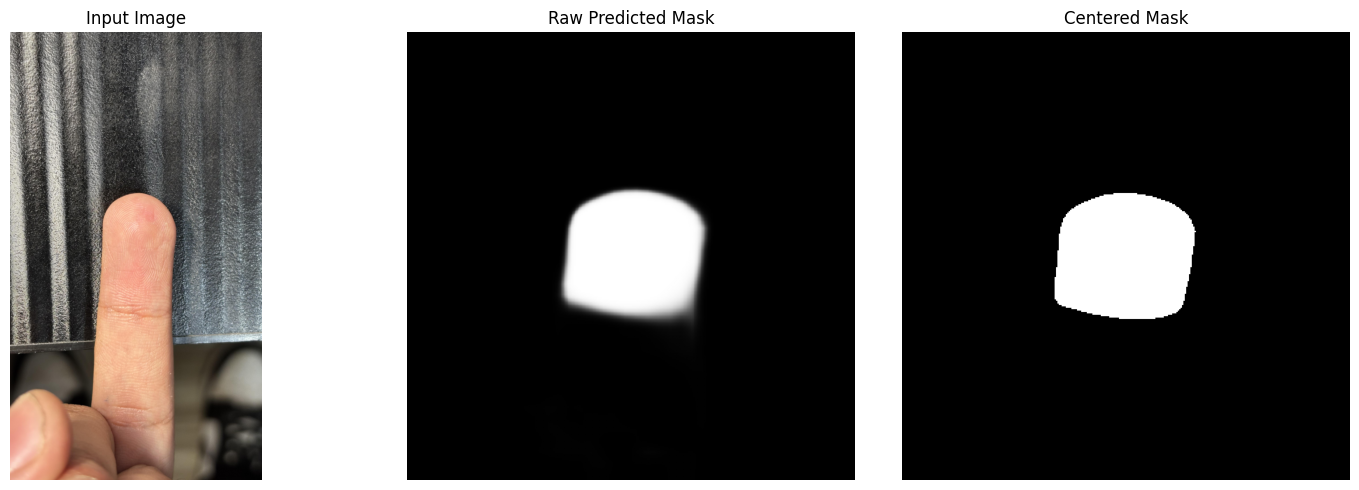

In [7]:
# Visualize
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Image.open(image_path))
axs[0].set_title("Input Image")
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title("Raw Predicted Mask")
axs[2].imshow(centered_mask, cmap='gray')
axs[2].set_title("Centered Mask")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()